In [1]:
import os
from os.path import exists, join

import matplotlib.animation as animation
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from tifffile import imread
import ffmpeg

pd.options.mode.chained_assignment = None  # default='warn'

### Parameters and path

In [2]:
um_per_pixel = 0.117
s_per_frame = 0.03
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig2_diffusion analysis/multi_stage_diffusion_examples/selected_montage"

os.chdir(folder_save)
video = imread("Merged_cropped_3stage_leaving.tif")
df = pd.read_csv("track.csv")
df = df.sort_values("t")

plow = 0.5  # imshow intensity percentile
phigh = 90
scalebar_color = "white"

cmap_color_start = "black"
cmap_color_end = "#B9DBF4"
cmap_name = "dark2blue"
cmap_blue = clr.LinearSegmentedColormap.from_list(
    cmap_name,
    [cmap_color_start, cmap_color_end],
)

cmap_color_start = (0.753, 0.22, 0.188, 0)
cmap_color_end = (0.753, 0.22, 0.188, 1)
cmap_name = "transparent2red"
cmap_red = clr.LinearSegmentedColormap.from_list(
    cmap_name,
    [cmap_color_start, cmap_color_end],
)

scalebar_length_um = 1
scalebar_length_pxl = scalebar_length_um / um_per_pixel
scale_bar_offset = 1

### All Frames but last, no scale bar

In [3]:
for frame in [10, 46, 66, 93, 115, 126, 137]:
    img_blue = video[frame - 1, 1, :, :]
    img_red = video[frame - 1, 0, :, :]
    fig, ax = plt.subplots(1, 1)
    plt.imshow(
        img_blue,
        cmap=cmap_blue,
        vmin=3100,
        vmax=5600,
    )
    plt.imshow(
        img_red,
        cmap=cmap_red,
        vmin=2,
        vmax=6,
    )

    # Add current circle
    current_x = df[df["t"] == frame - 1]["x"].squeeze()
    current_y = df[df["t"] == frame - 1]["y"].squeeze()
    c = plt.Circle(
        (current_x, current_y),
        2.5,
        color="white",
        fill=False,
        lw=3,
    )
    ax.add_patch(c)

    # Add track
    track = df[df["t"] <= frame - 1]
    plt.plot(
        track["x"],
        track["y"],
        color="white",
        lw=2,
        ls="-",
        marker="o",
    )

    plt.xlim(0, img_blue.shape[0])
    plt.ylim(0, img_blue.shape[1])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.axis("scaled")
    plt.axis("off")

    plt.savefig(
        str(frame) + ".png",
        format="png",
        bbox_inches="tight",
        dpi=300,
        transparent=True,
    )
    plt.close()

### Last frame with scale bar

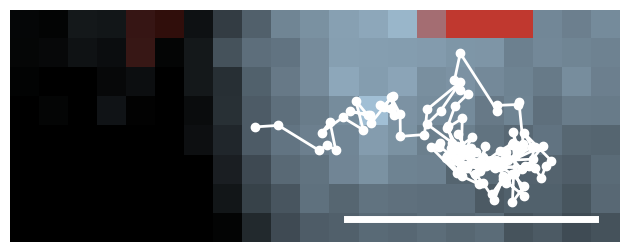

In [10]:
frame = 138
img_blue = video[frame - 1, 1, :, :]
img_red = video[frame - 1, 0, :, :]
fig, ax = plt.subplots(1, 1)
plt.imshow(
    img_blue,
    cmap=cmap_blue,
    vmin=3100,
    vmax=5600,
)
plt.imshow(
    img_red,
    cmap=cmap_red,
    vmin=2,
    vmax=6,
)

# Add track
track = df[df["t"] <= frame - 1]
plt.plot(
    track["x"],
    track["y"],
    color="white",
    lw=2,
    ls="-",
    marker="o",
)

# scale bar
scale_bar_offset = 0
scalebar_length_um = 1
base_x = 11.1
base_y = 6.7
scalebar_length_pxl = scalebar_length_um / um_per_pixel
plt.plot(
    [
        base_x + scale_bar_offset,
        base_x + scale_bar_offset + scalebar_length_pxl,
    ],
    [base_y + scale_bar_offset, base_y + scale_bar_offset],
    "-",
    color="white",
    lw=5,
)

plt.xlim(0, img_blue.shape[0])
plt.ylim(0, img_blue.shape[1])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.axis("scaled")
plt.axis("off")

plt.savefig(
    str(frame) + ".png",
    format="png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

### All frames with scale bar to video

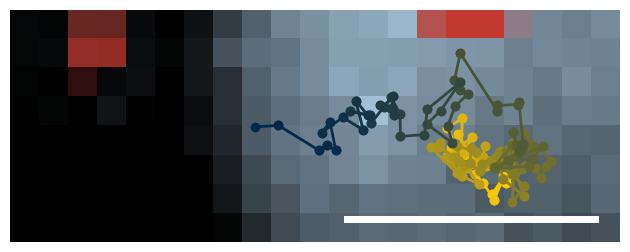

In [11]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1)
all_avaliable_frames = set(df["t"].unique())

cmap_color_end = "#00274C"
cmap_color_start = "#FFCB05"
cmap_name = "maize2blue"
N = track.shape[0]
cmap = clr.LinearSegmentedColormap.from_list(
    cmap_name, [cmap_color_start, cmap_color_end], N=N
)


def animate(frame):
    ax.clear()
    img_blue = video[frame - 1, 1, :, :]
    img_red = video[frame - 1, 0, :, :]
    plt.imshow(
        img_blue,
        cmap=cmap_blue,
        vmin=3100,
        vmax=5600,
    )
    plt.imshow(
        img_red,
        cmap=cmap_red,
        vmin=2,
        vmax=6,
    )
    # Add current circle, except for gaps
    if frame - 1 in all_avaliable_frames:
        current_x = df[df["t"] == frame - 1]["x"].squeeze()
        current_y = df[df["t"] == frame - 1]["y"].squeeze()
        c = plt.Circle(
            (current_x, current_y),
            1.3,
            color="white",
            fill=False,
            lw=3,
        )
        ax.add_patch(c)
    # Add track
    track = df[df["t"] <= frame - 1]
    t_plot = track["t"].to_numpy(float)
    x_plot = track["x"].to_numpy(float)
    y_plot = track["y"].to_numpy(float)
    for i in range(len(t_plot) - 1):
        plt.plot(
            x_plot[i : i + 2],
            y_plot[i : i + 2],
            "-o",
            color=cmap(i / N),
            lw=2,
        )
    # plt.plot(
    #     track["x"],
    #     track["y"],
    #     color="white",
    #     lw=2,
    #     ls="-",
    #     marker="o",
    # )
    # scale bar
    scale_bar_offset = 0
    scalebar_length_um = 1
    base_x = 11.1
    base_y = 6.7
    scalebar_length_pxl = scalebar_length_um / um_per_pixel
    plt.plot(
        [
            base_x + scale_bar_offset,
            base_x + scale_bar_offset + scalebar_length_pxl,
        ],
        [base_y + scale_bar_offset, base_y + scale_bar_offset],
        "-",
        color="white",
        lw=5,
    )
    plt.xlim(0, img_blue.shape[0])
    plt.ylim(0, img_blue.shape[1])
    ax.invert_yaxis()
    plt.tight_layout()
    plt.axis("scaled")
    plt.axis("off")


ani = FuncAnimation(fig, animate, frames=150, interval=20, repeat=False)
writer = animation.FFMpegWriter(fps=25)  # 25 Hz, 0.5x playback (original:50Hz)
ani.save("movie_0point5xplayback.mp4", writer=writer)